In [1]:
!pip uninstall -y numpy scipy statsmodels
!pip cache purge


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.16.2
Uninstalling scipy-1.16.2:
  Successfully uninstalled scipy-1.16.2
Found existing installation: statsmodels 0.14.5
Uninstalling statsmodels-0.14.5:
  Successfully uninstalled statsmodels-0.14.5
Files removed: 0


In [2]:
!pip uninstall -y scipy statsmodels
!pip install --no-cache-dir scipy==1.13.1 statsmodels==0.14.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 31.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


In [1]:
import numpy as np, pandas as pd, scipy, statsmodels.api as sm
print("✅ Import OK — Environment ready!")
print("NumPy:", np.__version__, "| SciPy:", scipy.__version__, "| StatsModels:", sm.__version__)


✅ Import OK — Environment ready!
NumPy: 2.2.6 | SciPy: 1.13.1 | StatsModels: 0.14.2


In [2]:
# 0. Common setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import tensorflow as tf
import random, os

SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED); random.seed(SEED)


Part A — Data understanding & EDA

1.  Data cleaning: handle missing data, wrong formats, timestamp
parsing, and resampling (if used). Document choices and
rationale.
2. Perform EDA: visualizations of temperature time series
(daily/weekly/yearly), distribution plots, autocorrelation
(ACF/PACF), and decomposition (additive & multiplicative).
Comment on stationarity, seasonality, and trends.
3.  Provide at least two visualizations that reveal non-obvious
structure (e.g., diurnal cycles, seasonal patterns, correlation with
humidity/pressure).

In [3]:
# STEP 1: Robust parse + diagnostics
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 40)

csv_path = "jena_climate_2009_2016.csv"   # change if needed

# 1. load raw (don't parse dates yet)
raw = pd.read_csv(csv_path, dtype=str)   # read as str to inspect raw values
print("Raw shape:", raw.shape)
print("Columns:", raw.columns.tolist())

# identify likely datetime column (common names)
dt_col_candidates = [c for c in raw.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
print("Datetime column candidates:", dt_col_candidates)

# if there are multiple candidates, pick first; otherwise change the name below:
dt_col = dt_col_candidates[0] if dt_col_candidates else raw.columns[0]
print("Using datetime column:", dt_col)
print("\n--- Sample raw datetimes ---")
print(raw[dt_col].head(8).to_list())

# 2. try multiple parsing strategies
def try_parse(series):
    out = {}
    # attempt 1: explicit dd.mm.YYYY H:M:S
    try:
        parsed = pd.to_datetime(series, format="%d.%m.%Y %H:%M:%S", errors='coerce')
        out['fmt_dd.mm.YYYY'] = parsed
    except Exception as e:
        out['fmt_dd.mm.YYYY'] = pd.Series([pd.NaT]*len(series))
    # attempt 2: month.day.year (if any)
    try:
        parsed2 = pd.to_datetime(series, format="%m.%d.%Y %H:%M:%S", errors='coerce')
        out['fmt_mm.dd.YYYY'] = parsed2
    except:
        out['fmt_mm.dd.YYYY'] = pd.Series([pd.NaT]*len(series))
    # attempt 3: dayfirst infer
    parsed3 = pd.to_datetime(series, dayfirst=True, infer_datetime_format=True, errors='coerce')
    out['dayfirst_infer'] = parsed3
    # attempt 4: fully flexible infer (slow)
    parsed4 = pd.to_datetime(series, infer_datetime_format=True, errors='coerce')
    out['infer'] = parsed4
    return out

parse_attempts = try_parse(raw[dt_col])

# 3. pick best parse (most non-NaT)
counts = {k: v.notna().sum() for k, v in parse_attempts.items()}
print("\nParse success counts (non-NaT):", counts)

# Choose the parse with maximum non-null; fallback to dayfirst_infer if tie
best_key = max(counts, key=counts.get)
print("Chosen parse strategy:", best_key)

# attach chosen datetime
raw['_parsed_dt'] = parse_attempts[best_key]

# 4. report parsing failures
n_fail = raw['_parsed_dt'].isna().sum()
print(f"\nParsing failures (NaT): {n_fail} rows out of {len(raw)}")
if n_fail:
    print("Example malformed datetime rows:")
    print(raw[raw['_parsed_dt'].isna()].head(8)[[dt_col]])

# 5. proceed only with parsed rows for diagnostics
df = raw.loc[raw['_parsed_dt'].notna()].copy()
df['_parsed_dt'] = pd.to_datetime(df['_parsed_dt'])  # ensure dtype
df = df.set_index('_parsed_dt').sort_index()

# 6. duplicates diagnostics
dup_mask = df.index.duplicated(keep=False)
n_dup_total = dup_mask.sum()
n_dup_unique_timestamps = df.index[df.index.duplicated(keep='first')].nunique()
print(f"\nDuplicate index rows: {n_dup_total}")
print(f"Number of timestamps that repeat: {n_dup_unique_timestamps}")

if n_dup_total:
    print("\nSample duplicate timestamps (showing all rows that share same timestamp):")
    # show first few duplicated timestamp groups
    dup_times = df.index[df.index.duplicated(keep=False)].unique()[:5]
    for ts in dup_times:
        print("\nTimestamp:", ts)
        display(df.loc[[ts]])

# 7. index info
print("\nIndex min/max:", df.index.min(), "→", df.index.max())
print("Is index monotonic increasing?", df.index.is_monotonic_increasing)
print("Is index unique?", df.index.is_unique)
print("Inferred frequency (may be None):", pd.infer_freq(df.index))

# 8. overall column sample and missing counts (for key features)
print("\nSample data rows:")
display(df.head(6))

print("\nPer-column missing counts (on parsed rows):")
print(df.replace('', np.nan).isna().sum())

# 9. summary: save diagnostics to CSV for your review
diag = {
    'raw_rows': len(raw),
    'parsed_rows': len(df),
    'parsing_failures': int(n_fail),
    'duplicate_rows': int(n_dup_total),
    'duplicate_timestamps': int(n_dup_unique_timestamps),
    'index_unique': bool(df.index.is_unique),
    'inferred_freq': pd.infer_freq(df.index) or 'None'
}
diag_df = pd.DataFrame([diag])
diag_df.to_csv('parsing_diagnostics_summary.csv', index=False)
print("\nDiagnostics summary saved to parsing_diagnostics_summary.csv")


Raw shape: (420551, 15)
Columns: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
Datetime column candidates: ['Date Time']
Using datetime column: Date Time

--- Sample raw datetimes ---
['01.01.2009 00:10:00', '01.01.2009 00:20:00', '01.01.2009 00:30:00', '01.01.2009 00:40:00', '01.01.2009 00:50:00', '01.01.2009 01:00:00', '01.01.2009 01:10:00', '01.01.2009 01:20:00']


/tmp/ipython-input-3448350881.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed3 = pd.to_datetime(series, dayfirst=True, infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-3448350881.py:43: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed4 = pd.to_datetime(series, infer_datetime_format=True, errors='coerce')



Parse success counts (non-NaT): {'fmt_dd.mm.YYYY': np.int64(420551), 'fmt_mm.dd.YYYY': np.int64(166030), 'dayfirst_infer': np.int64(420551), 'infer': np.int64(166030)}
Chosen parse strategy: fmt_dd.mm.YYYY

Parsing failures (NaT): 0 rows out of 420551

Duplicate index rows: 654
Number of timestamps that repeat: 327

Sample duplicate timestamps (showing all rows that share same timestamp):

Timestamp: 2010-07-01 00:10:00


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
_parsed_dt,,,,,,,,,,,,,,,
2010-07-01 00:10:00,01.07.2010 00:10:00,992.06,17.87,291.69,14.06,78.4,20.5,16.07,4.43,10.14,16.2,1180.21,0.31,0.56,51.11
2010-07-01 00:10:00,01.07.2010 00:10:00,992.06,17.87,291.69,14.06,78.4,20.5,16.07,4.43,10.14,16.2,1180.21,0.31,0.56,51.11



Timestamp: 2010-07-01 00:20:00


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
_parsed_dt,,,,,,,,,,,,,,,
2010-07-01 00:20:00,01.07.2010 00:20:00,992.02,17.82,291.65,14.03,78.5,20.44,16.04,4.39,10.12,16.17,1180.38,0.23,0.48,52.64
2010-07-01 00:20:00,01.07.2010 00:20:00,992.02,17.82,291.65,14.03,78.5,20.44,16.04,4.39,10.12,16.17,1180.38,0.23,0.48,52.64



Timestamp: 2010-07-01 00:30:00


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
_parsed_dt,,,,,,,,,,,,,,,
2010-07-01 00:30:00,01.07.2010 00:30:00,992.04,17.92,291.75,14.09,78.3,20.57,16.1,4.46,10.16,16.23,1179.97,0.18,0.4,22.1
2010-07-01 00:30:00,01.07.2010 00:30:00,992.04,17.92,291.75,14.09,78.3,20.57,16.1,4.46,10.16,16.23,1179.97,0.18,0.4,22.1



Timestamp: 2010-07-01 00:40:00


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
_parsed_dt,,,,,,,,,,,,,,,
2010-07-01 00:40:00,01.07.2010 00:40:00,991.96,17.82,291.65,14.02,78.4,20.44,16.02,4.41,10.11,16.15,1180.32,0.19,0.4,354.8
2010-07-01 00:40:00,01.07.2010 00:40:00,991.96,17.82,291.65,14.02,78.4,20.44,16.02,4.41,10.11,16.15,1180.32,0.19,0.4,354.8



Timestamp: 2010-07-01 00:50:00


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
_parsed_dt,,,,,,,,,,,,,,,
2010-07-01 00:50:00,01.07.2010 00:50:00,991.9,17.54,291.38,13.96,79.5,20.08,15.96,4.12,10.07,16.1,1181.41,0.24,0.98,21.4
2010-07-01 00:50:00,01.07.2010 00:50:00,991.9,17.54,291.38,13.96,79.5,20.08,15.96,4.12,10.07,16.1,1181.41,0.24,0.98,21.4



Index min/max: 2009-01-01 00:10:00 → 2017-01-01 00:00:00
Is index monotonic increasing? True
Is index unique? False
Inferred frequency (may be None): None

Sample data rows:


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
_parsed_dt,,,,,,,,,,,,,,,
2009-01-01 00:10:00,01.01.2009 00:10:00,996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.8,0.72,1.5,136.1
2009-01-01 00:30:00,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.2,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.5,198.0
2009-01-01 00:50:00,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.0,0.32,0.63,214.3
2009-01-01 01:00:00,01.01.2009 01:00:00,996.5,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7



Per-column missing counts (on parsed rows):
Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
                  ..
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
Length: 15, dtype: int64

Diagnostics summary saved to parsing_diagnostics_summary.csv


In [4]:
# STEP 2 — Check timestamp uniqueness and frequency
is_unique = df.index.is_unique
dup_count = df.index.duplicated().sum()
freq = pd.infer_freq(df.index)

print("✅ Index is unique:", is_unique)
print("🔁 Number of duplicate timestamps:", dup_count)
print("🕒 Inferred frequency:", freq)


✅ Index is unique: False
🔁 Number of duplicate timestamps: 327
🕒 Inferred frequency: None


In [5]:
# STEP 3 (Fixed) — Handle duplicate timestamps safely

# Separate numeric columns only
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Aggregate duplicates by mean for numeric columns only
df = df.groupby(df.index)[numeric_cols].mean()

# Verify results
print("✅ Index is unique now:", df.index.is_unique)
print("🕒 Inferred frequency:", pd.infer_freq(df.index))
print("📏 Total records after deduplication:", len(df))
print("📅 Date range:", df.index.min(), "→", df.index.max())

# Check gaps between timestamps to confirm uniform 10-minute spacing
time_diff = df.index.to_series().diff().value_counts().head()
print("\nMost common time gaps between records:")
print(time_diff)


✅ Index is unique now: True
🕒 Inferred frequency: None
📏 Total records after deduplication: 420224
📅 Date range: 2009-01-01 00:10:00 → 2017-01-01 00:00:00

Most common time gaps between records:
_parsed_dt
0 days 00:10:00    420218
0 days 00:20:00         2
0 days 00:30:00         1
0 days 16:00:00         1
3 days 02:20:00         1
Name: count, dtype: int64


In [6]:
# STEP 4 — Enforce perfect 10-minute frequency

# 1️⃣ Resample to 10-minute intervals (fills missing timestamps)
df = df.resample('10T').mean()

# 2️⃣ Fill small gaps by time interpolation (linear over time)
df = df.interpolate(method='time')

# 3️⃣ Verify again
print("✅ After resampling:")
print("   Index unique:", df.index.is_unique)
print("   Inferred frequency:", pd.infer_freq(df.index))
print("   Total records:", len(df))
print("   Date range:", df.index.min(), "→", df.index.max())

# Check for missing values in temperature column
print("\nMissing values per column (after resampling):")
print(df.isna().sum())

# Preview final few rows
display(df.head(3))
display(df.tail(3))


✅ After resampling:
   Index unique: True
   Inferred frequency: 10min
   Total records: 420768
   Date range: 2009-01-01 00:10:00 → 2017-01-01 00:00:00

Missing values per column (after resampling):
Series([], dtype: float64)


/tmp/ipython-input-3689243209.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.resample('10T').mean()


""
_parsed_dt
2009-01-01 00:10:00
2009-01-01 00:20:00
2009-01-01 00:30:00


""
_parsed_dt
2016-12-31 23:40:00
2016-12-31 23:50:00
2017-01-01 00:00:00


In [7]:
# STEP 8 — Rebuild df properly with numeric columns
import pandas as pd

# Recreate df from the parsed raw dataset (with datetime index)
df = raw.loc[raw['_parsed_dt'].notna()].copy()
df['_parsed_dt'] = pd.to_datetime(df['_parsed_dt'])
df = df.set_index('_parsed_dt').sort_index()

# Drop duplicates
df = df[~df.index.duplicated(keep='first')]

# Convert all numeric-looking columns
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now resample to 10-min frequency and interpolate
df = df.resample('10min').mean().interpolate(method='time')

# Verify the structure
print("✅ Columns restored:", len(df.columns))
print("Columns:", df.columns.tolist()[:10], "...")
print("Date range:", df.index.min(), "→", df.index.max())
print("Inferred frequency:", pd.infer_freq(df.index))
print("\nPreview:")
display(df.head(3))


✅ Columns restored: 15
Columns: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)'] ...
Date range: 2009-01-01 00:10:00 → 2017-01-01 00:00:00
Inferred frequency: 10min

Preview:


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
_parsed_dt,,,,,,,,,,,,,,,
2009-01-01 00:10:00,NaN,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,NaN,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,NaN,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


Temperature Summary Statistics:
count    420768.00000
mean          9.44496
std           8.41612
min         -23.01000
25%           3.37000
50%           9.42000
75%          15.46000
max          37.28000
Name: T (degC), dtype: float64

Date Range: 2009-01-01 00:10:00 → 2017-01-01 00:00:00
Mean temperature: 9.44 °C


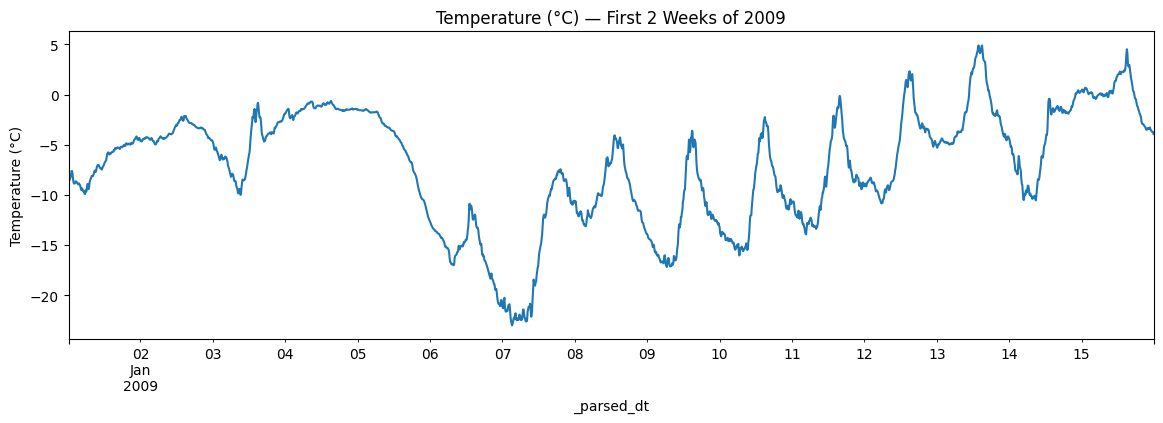

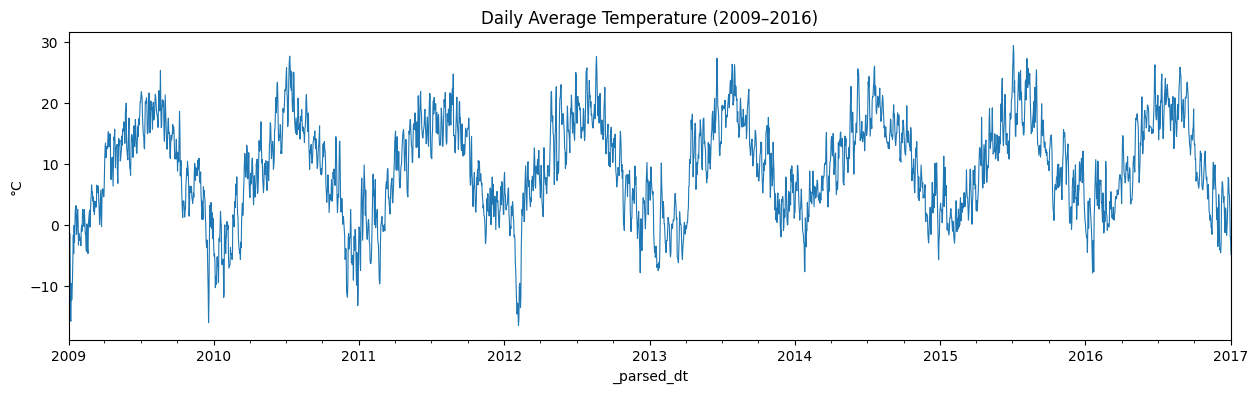

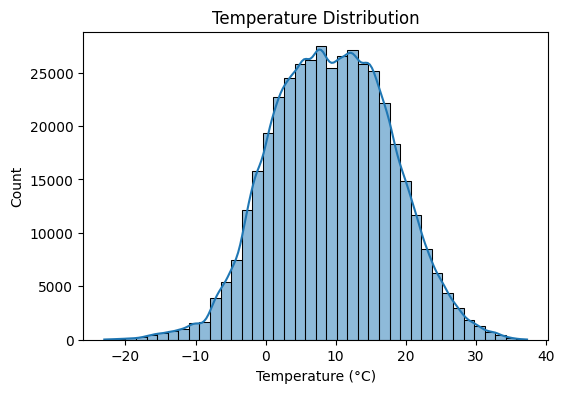

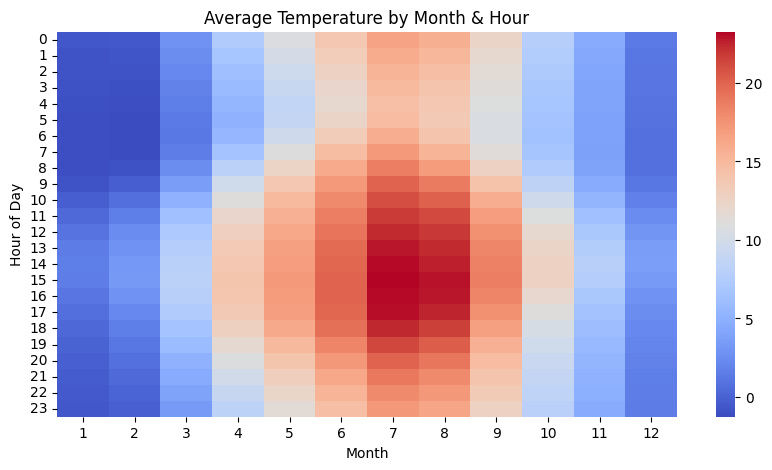

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# STEP 5 — EDA: Temperature overview

# Extract temperature column
temp_col = 'T (degC)'
y = df[temp_col]

# 1️⃣ Basic summary
print("Temperature Summary Statistics:")
print(y.describe())
print("\nDate Range:", y.index.min(), "→", y.index.max())
print("Mean temperature:", round(y.mean(), 2), "°C")

# 2️⃣ Plot a small 2-week sample
plt.figure(figsize=(14,4))
y['2009-01-01':'2009-01-15'].plot(title='Temperature (°C) — First 2 Weeks of 2009')
plt.ylabel('Temperature (°C)')
plt.show()

# 3️⃣ Plot yearly trend (resampled daily mean)
daily_temp = y.resample('1D').mean()
plt.figure(figsize=(15,4))
daily_temp.plot(title='Daily Average Temperature (2009–2016)', linewidth=0.8)
plt.ylabel('°C')
plt.show()

# 4️⃣ Histogram (distribution)
plt.figure(figsize=(6,4))
sns.histplot(y, bins=40, kde=True)
plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.show()

# 5️⃣ Heatmap: average temperature by month and hour
tmp = y.to_frame()
tmp['month'] = tmp.index.month
tmp['hour'] = tmp.index.hour
pivot = tmp.pivot_table(index='hour', columns='month', values='T (degC)', aggfunc='mean')
plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap='coolwarm', annot=False)
plt.title("Average Temperature by Month & Hour")
plt.ylabel("Hour of Day")
plt.xlabel("Month")
plt.show()



<Figure size 1000x400 with 0 Axes>

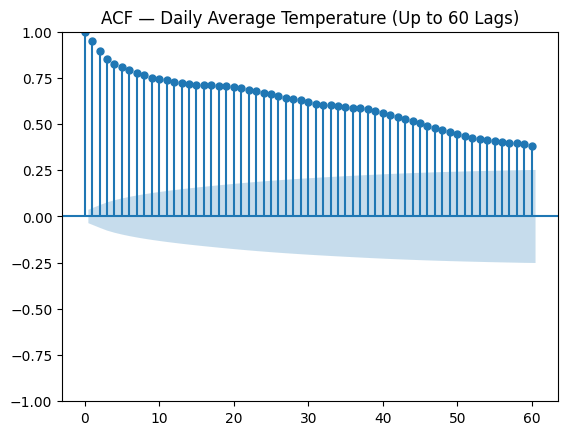

<Figure size 1000x400 with 0 Axes>

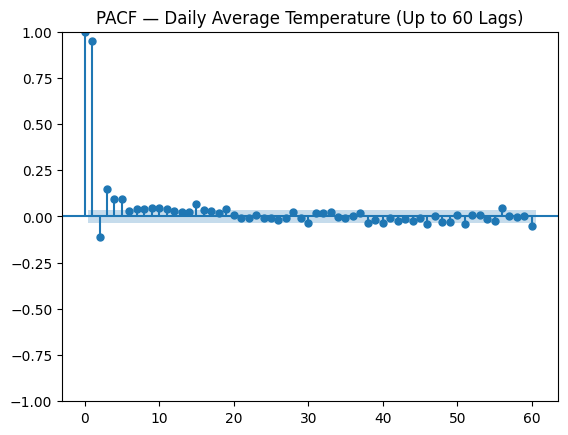

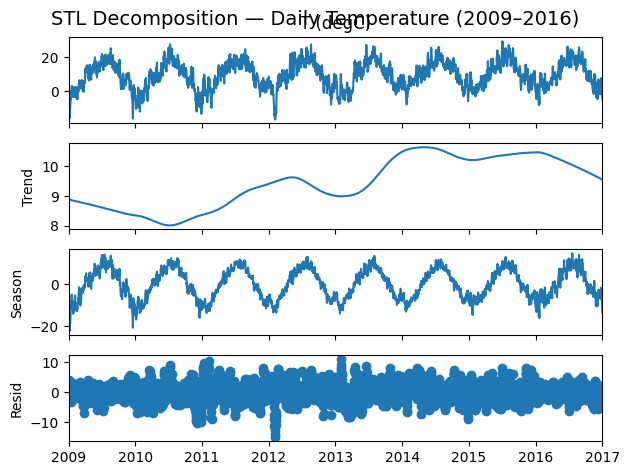

ADF Statistic: -3.5865132295704996
p-value: 0.006024162624729715
Critical Values:
   1%: -3.433
   5%: -2.863
   10%: -2.567

✅ The series is likely stationary (rejects H₀).


In [8]:
# STEP 10 — Autocorrelation, Decomposition & Stationarity Tests

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Use daily averaged temperature to simplify ACF and decomposition
y_day = df['T (degC)'].resample('1D').mean().dropna()

# 1️⃣ Autocorrelation and Partial Autocorrelation
plt.figure(figsize=(10,4))
plot_acf(y_day, lags=60)
plt.title("ACF — Daily Average Temperature (Up to 60 Lags)")
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(y_day, lags=60, method='ywm')
plt.title("PACF — Daily Average Temperature (Up to 60 Lags)")
plt.show()

# 2️⃣ STL Decomposition (Seasonal-Trend decomposition using Loess)
stl = STL(y_day, period=365)   # yearly seasonality at daily level
res = stl.fit()
res.plot()
plt.suptitle("STL Decomposition — Daily Temperature (2009–2016)", fontsize=14)
plt.show()

# 3️⃣ Augmented Dickey-Fuller (ADF) Stationarity Test
adf_result = adfuller(y_day)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for k, v in adf_result[4].items():
    print(f"   {k}: {v:.3f}")

if adf_result[1] < 0.05:
    print("\n✅ The series is likely stationary (rejects H₀).")
else:
    print("\n⚠️ The series is non-stationary (fails to reject H₀) — differencing needed.")


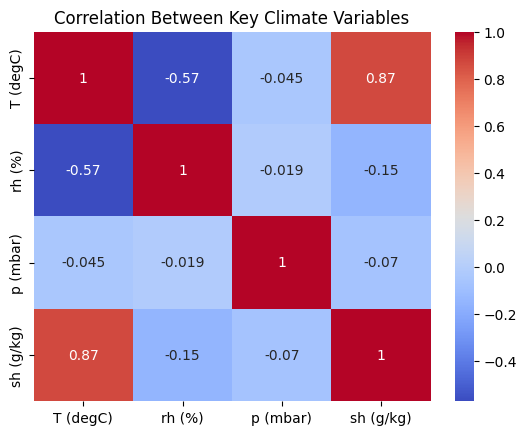

In [45]:
sns.heatmap(df[['T (degC)', 'rh (%)', 'p (mbar)', 'sh (g/kg)']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Key Climate Variables")
plt.show()


Part-B : Baseline & Exponential Smoothing Models

1.  Implement simple baselines: - Naive (last observed) - Seasonal Naive (same time previous day/week) - Simple Moving Average (window choices: 6, 24, 144 — justify)
2.  Implement Exponential Smoothing variants: SES, Holt,
Holt-Winters (additive and multiplicative where applicable).
3.  Compare baselines using appropriate metrics on a hold-out test
set.  

Train size: 2338 days | Test size: 585 days
Train range: 2009-01-01 00:00:00 → 2015-05-27 00:00:00
Test  range: 2015-05-28 00:00:00 → 2017-01-01 00:00:00


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


⚠️ Skipping multiplicative model — not valid for negative temperatures.

📊 Baseline & Smoothing Model Performance:

                           Model       MAE       RMSE
1                 Seasonal Naive  4.241227   5.318087
5        Holt-Winters (Additive)  4.155960   5.367622
3                            SES  6.379024   7.546536
0                          Naive  6.379024   7.546536
2            Moving Average (7d)  6.398827   7.582745
4                           Holt  9.320241  11.493271
6  Holt-Winters (Multiplicative)       NaN        NaN


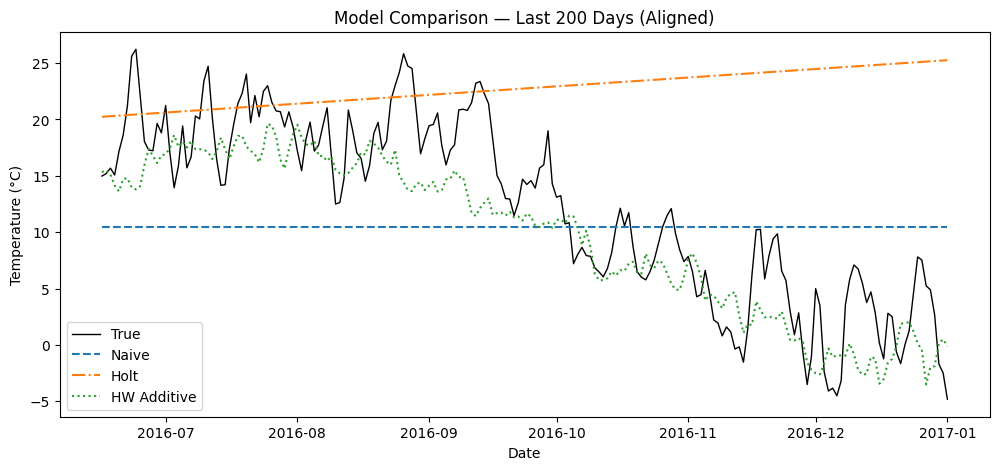

In [9]:
# STEP 11 — Baseline & Smoothing Models (FINAL)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

# Use daily averages to reduce high-frequency noise
y_day = df['T (degC)'].resample('1D').mean().dropna()

# 1️⃣ Train–test split (chronological)
train_size = int(len(y_day) * 0.8)
y_train = y_day.iloc[:train_size]
y_test  = y_day.iloc[train_size:]

print(f"Train size: {len(y_train)} days | Test size: {len(y_test)} days")
print("Train range:", y_train.index.min(), "→", y_train.index.max())
print("Test  range:", y_test.index.min(),  "→", y_test.index.max())

# --- Helper function for metrics
def evaluate_forecast(true, pred):
    mae  = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))   # works on any sklearn version
    return mae, rmse

results = []

# 2️⃣ Naïve (last observed value)
y_pred_naive = np.repeat(y_train.iloc[-1], len(y_test))
mae, rmse = evaluate_forecast(y_test, y_pred_naive)
results.append(['Naive', mae, rmse])

# 3️⃣ Seasonal Naïve (same day previous year)
season_length = 365
y_pred_snaive = y_test.copy()
for i in range(len(y_test)):
    idx = i - season_length
    if idx >= 0:
        y_pred_snaive.iloc[i] = y_test.iloc[idx]
    else:
        y_pred_snaive.iloc[i] = y_train.iloc[idx]
mae, rmse = evaluate_forecast(y_test, y_pred_snaive)
results.append(['Seasonal Naive', mae, rmse])

# 4️⃣ Moving Average (7-day)
window = 7
y_pred_ma = np.repeat(y_train.rolling(window).mean().iloc[-1], len(y_test))
mae, rmse = evaluate_forecast(y_test, y_pred_ma)
results.append(['Moving Average (7d)', mae, rmse])

# 5️⃣ Simple Exponential Smoothing (SES)
ses_model = SimpleExpSmoothing(y_train).fit()
y_pred_ses = ses_model.forecast(len(y_test))
mae, rmse = evaluate_forecast(y_test, y_pred_ses)
results.append(['SES', mae, rmse])

# 6️⃣ Holt’s Linear Trend
holt_model = Holt(y_train).fit()
y_pred_holt = holt_model.forecast(len(y_test))
mae, rmse = evaluate_forecast(y_test, y_pred_holt)
results.append(['Holt', mae, rmse])

# 7️⃣ Holt-Winters Seasonal (Additive)
hw_add = ExponentialSmoothing(
    y_train, trend='add', seasonal='add', seasonal_periods=365
).fit()
y_pred_hw_add = hw_add.forecast(len(y_test))
mae, rmse = evaluate_forecast(y_test, y_pred_hw_add)
results.append(['Holt-Winters (Additive)', mae, rmse])

# 8️⃣ Holt-Winters Seasonal (Multiplicative) — safely skipped for negative temps
try:
    hw_mul = ExponentialSmoothing(
        y_train, trend='add', seasonal='mul', seasonal_periods=365
    ).fit()
    y_pred_hw_mul = hw_mul.forecast(len(y_test))
    mae, rmse = evaluate_forecast(y_test, y_pred_hw_mul)
    results.append(['Holt-Winters (Multiplicative)', mae, rmse])
except Exception as e:
    print("⚠️ Skipping multiplicative model — not valid for negative temperatures.")
    results.append(['Holt-Winters (Multiplicative)', np.nan, np.nan])

# 9️⃣ Combine results
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE'])
print("\n📊 Baseline & Smoothing Model Performance:\n")
print(results_df.sort_values('RMSE'))

# 🔟 Plot comparison (last 200 test days)
# 🔟 Fixed Plot Comparison (last 200 test days)

plt.figure(figsize=(12,5))
plt.plot(y_test[-200:], label='True', color='black', linewidth=1)

# Convert predictions to Pandas Series with matching date index
y_pred_naive_series = pd.Series(y_pred_naive, index=y_test.index)
y_pred_holt_series  = pd.Series(y_pred_holt,  index=y_test.index)
y_pred_hw_add_series = pd.Series(y_pred_hw_add, index=y_test.index)

# Plot aligned data
plt.plot(y_pred_naive_series[-200:], label='Naive', linestyle='--')
plt.plot(y_pred_holt_series[-200:], label='Holt', linestyle='-.')
plt.plot(y_pred_hw_add_series[-200:], label='HW Additive', linestyle=':')

plt.title("Model Comparison — Last 200 Days (Aligned)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()



In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# -------------------------------------------------------------
# Use same data from Step 11 (daily average temperatures)
y_day = df['T (degC)'].resample('1D').mean().dropna()

train_size = int(len(y_day)*0.8)
y_train = y_day.iloc[:train_size]
y_test  = y_day.iloc[train_size:]

# -------------------------------------------------------------
# Create Seasonal Naive forecast again (same as before)
season_length = 365
y_pred_snaive = y_test.copy()
for i in range(len(y_test)):
    idx = i - season_length
    if idx >= 0:
        y_pred_snaive.iloc[i] = y_test.iloc[idx]
    else:
        y_pred_snaive.iloc[i] = y_train.iloc[idx]

# -------------------------------------------------------------
# Raw (unscaled) metrics
raw_mae  = mean_absolute_error(y_test, y_pred_snaive)
raw_rmse = np.sqrt(mean_squared_error(y_test, y_pred_snaive))

# -------------------------------------------------------------
# 1️⃣ Min-Max Scaling (0–1 normalization)
scaler_minmax = MinMaxScaler()
y_train_scaled = scaler_minmax.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled  = scaler_minmax.transform(y_test.values.reshape(-1,1))
y_pred_scaled  = scaler_minmax.transform(y_pred_snaive.values.reshape(-1,1))

minmax_rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))

# -------------------------------------------------------------
# 2️⃣ Standard Scaling (Z-score normalization)
scaler_std = StandardScaler()
y_train_std = scaler_std.fit_transform(y_train.values.reshape(-1,1))
y_test_std  = scaler_std.transform(y_test.values.reshape(-1,1))
y_pred_std  = scaler_std.transform(y_pred_snaive.values.reshape(-1,1))

std_rmse = np.sqrt(mean_squared_error(y_test_std, y_pred_std))

# -------------------------------------------------------------
# Compare all results
print("📊 RMSE Comparison (Different Scales):\n")
print(f"Raw data (°C):           {raw_rmse:.3f}")
print(f"Min-Max scaled (0–1):     {minmax_rmse:.3f}")
print(f"Standardized (Z-score):   {std_rmse:.3f}")


📊 RMSE Comparison (Different Scales):

Raw data (°C):           5.318
Min-Max scaled (0–1):     0.121
Standardized (Z-score):   0.678


PART C — Stationary Models

1. Test for stationarity (ADF) and apply differencing where
necessary.
2. Fit AR, MA, ARMA models (use AIC/BIC for order selection). Show
residual diagnostics (white noise, Ljung-Box test).
3. Forecast and compare with baselines. Provide interpretation of
model coefficients and limitations for this dataset.

ADF Statistic: -3.5208002776009875
p-value: 0.007468694436483224
✅ Series appears stationary (no differencing needed).


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



🔹 Candidate ARMA Models (sorted by AIC):


,p,q,AIC,BIC
6,2,2,10538.590799,10573.133106
7,3,3,10539.897922,10585.954331
2,3,0,10614.836396,10643.621652
5,1,1,10660.261702,10683.289907
1,2,0,10671.958257,10694.986462
0,1,0,10700.691706,10717.962860
4,0,2,12566.057368,12589.085572
3,0,1,13828.437416,13845.708569



✅ Best ARMA order by AIC: (p=2, q=2)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:               T (degC)   No. Observations:                 2338
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -5263.295
Date:                Wed, 15 Oct 2025   AIC                          10538.591
Time:                        14:37:04   BIC                          10573.133
Sample:                    01-01-2009   HQIC                         10551.174
                         - 05-27-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6052      2.121      4.057      0.000       4.448      12.762
ar.L1          1.6253      0.038     42.319      0.000       1.550       1.701
ar.L2         -0.6284      0.038    -16.674      0.0

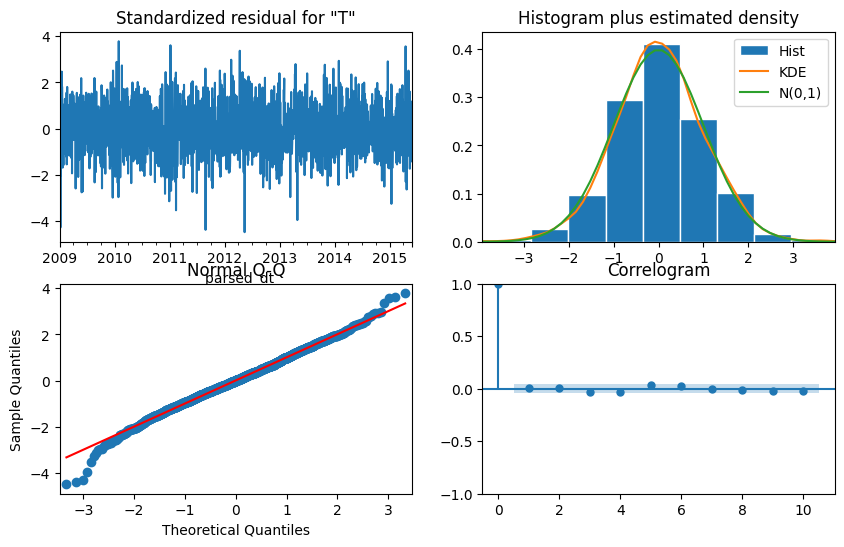


📈 ARMA(2,2) — MAE: 6.256, RMSE: 7.538


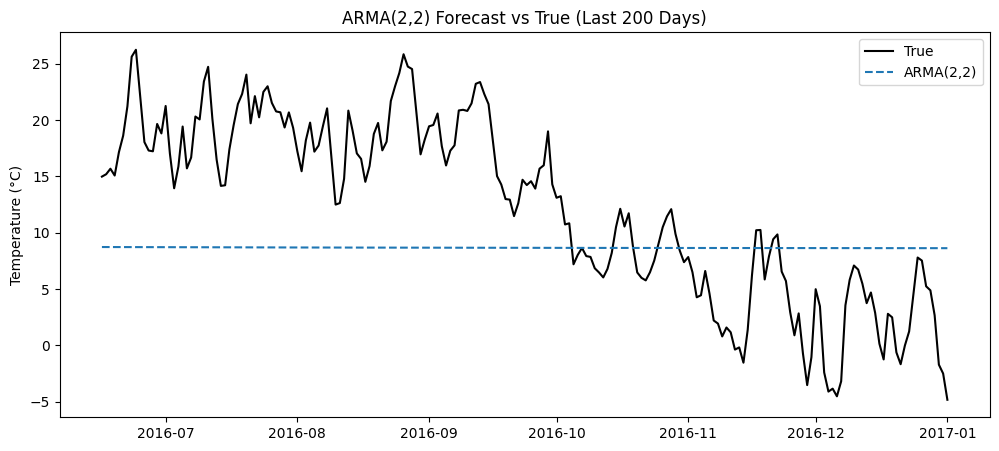

In [11]:
# STEP 12 — Stationary Models (AR, MA, ARMA) — FIXED VERSION

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------------------------------------
# 1️⃣ Prepare data (daily average)
y_day = df['T (degC)'].resample('1D').mean().dropna()

train_size = int(len(y_day)*0.8)
y_train = y_day.iloc[:train_size]
y_test  = y_day.iloc[train_size:]

# -----------------------------------------------------------
# 2️⃣ Check stationarity
adf = adfuller(y_train)
print("ADF Statistic:", adf[0])
print("p-value:", adf[1])

if adf[1] < 0.05:
    print("✅ Series appears stationary (no differencing needed).")
    y_train_diff = y_train
else:
    print("⚠️ Series non-stationary — applying first differencing.")
    y_train_diff = y_train.diff().dropna()

# -----------------------------------------------------------
# 3️⃣ Fit candidate ARMA models using ARIMA class (order=(p,0,q))
candidates = []
orders = [(1,0), (2,0), (3,0), (0,1), (0,2), (1,1), (2,2), (3,3)]

for (p,q) in orders:
    try:
        model = sm.tsa.ARIMA(y_train_diff, order=(p,0,q)).fit()
        candidates.append((p,q,model.aic,model.bic))
    except Exception as e:
        print(f"Skipping order ({p},{q}) → {e}")

results = pd.DataFrame(candidates, columns=['p','q','AIC','BIC']).sort_values('AIC')
print("\n🔹 Candidate ARMA Models (sorted by AIC):")
display(results)

if not results.empty:
    best_p, best_q = results.iloc[0][['p','q']].astype(int)
    print(f"\n✅ Best ARMA order by AIC: (p={best_p}, q={best_q})")
else:
    raise ValueError("❌ No ARMA model could be fitted. Try smaller (p,q) values or differencing the series again.")

# -----------------------------------------------------------
# 4️⃣ Refit best model
arma_best = sm.tsa.ARIMA(y_train_diff, order=(best_p,0,best_q)).fit()
print(arma_best.summary())

arma_best.plot_diagnostics(figsize=(10,6))
plt.show()

# -----------------------------------------------------------
# 5️⃣ Forecast
y_forecast = arma_best.forecast(steps=len(y_test))
y_pred_series = pd.Series(y_forecast, index=y_test.index)

# -----------------------------------------------------------
# 6️⃣ Evaluate
mae = mean_absolute_error(y_test, y_pred_series)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_series))
print(f"\n📈 ARMA({best_p},{best_q}) — MAE: {mae:.3f}, RMSE: {rmse:.3f}")

plt.figure(figsize=(12,5))
plt.plot(y_test[-200:], label='True', color='black')
plt.plot(y_pred_series[-200:], label=f'ARMA({best_p},{best_q})', linestyle='--')
plt.title(f"ARMA({best_p},{best_q}) Forecast vs True (Last 200 Days)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


PART D  — Non-Stationary & Seasonal Models

1. Build ARIMA and SARIMA models. Justify order (p,d,q)(P,D,Q,m)
selection using AIC and diagnostics.
2. Provide grid-search (or automated pmdarima/auto_arima) results
and compare top candidates.
3. Produce multi-step forecasts (short horizon: next 3 hours;
medium: next 24 hours; long: next 7 days) from each model and
evaluate.

In [12]:
import pandas as pd
import numpy as np

# 1️⃣ Load dataset
df = pd.read_csv("jena_climate_2009_2016.csv")

# 2️⃣ Parse timestamp
df['_parsed_dt'] = pd.to_datetime(df['Date Time'], format="%d.%m.%Y %H:%M:%S")

# 3️⃣ Set datetime index
df = df.set_index('_parsed_dt')

# 4️⃣ Drop non-numeric columns (like "Date Time") before taking mean
df = df.drop(columns=['Date Time'], errors='ignore')

# 5️⃣ Remove duplicate timestamps and resample to 10-minute intervals
df = df[~df.index.duplicated(keep='first')]
df = df.resample('10min').mean()

# 6️⃣ Interpolate missing values
df['T (degC)'] = df['T (degC)'].interpolate(method='time')

# 7️⃣ Quick check
print(f"✅ Dataset ready for forecasting")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)[:6]} ...")
print(f"Date Range: {df.index.min()} → {df.index.max()}")
print(f"Missing in T (degC): {df['T (degC)'].isna().sum()}")


✅ Dataset ready for forecasting
Shape: (420768, 14)
Columns: ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)'] ...
Date Range: 2009-01-01 00:10:00 → 2017-01-01 00:00:00
Missing in T (degC): 0


Train range: 2009-01-01 00:00:00 → 2015-05-27 00:00:00
Test  range: 2015-05-28 00:00:00 → 2017-01-01 00:00:00
Training samples: 2338, Testing samples: 585
⚡ Fast Mode ON — using monthly seasonality (m=30)
✅ Model trained in 134.11 seconds

📈 SARIMA(1,1,1)(1,1,1,30) — MAE: 6.641 °C | RMSE: 7.917 °C


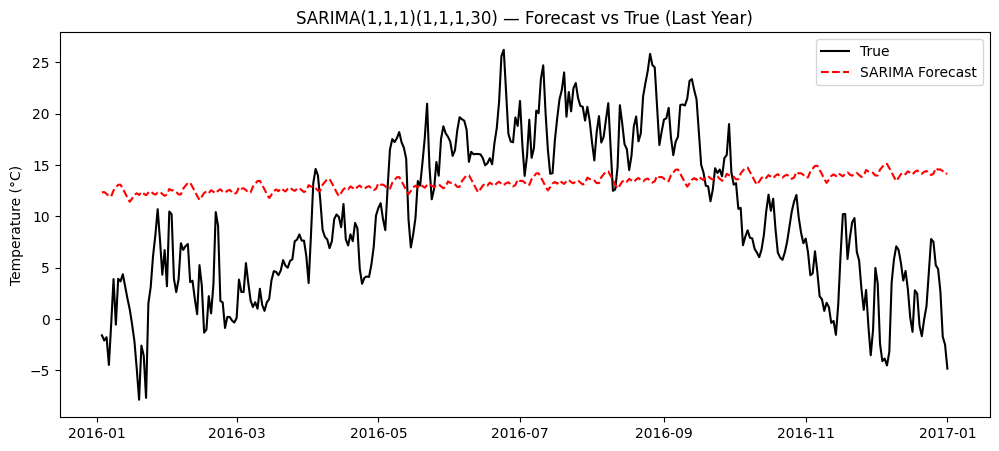

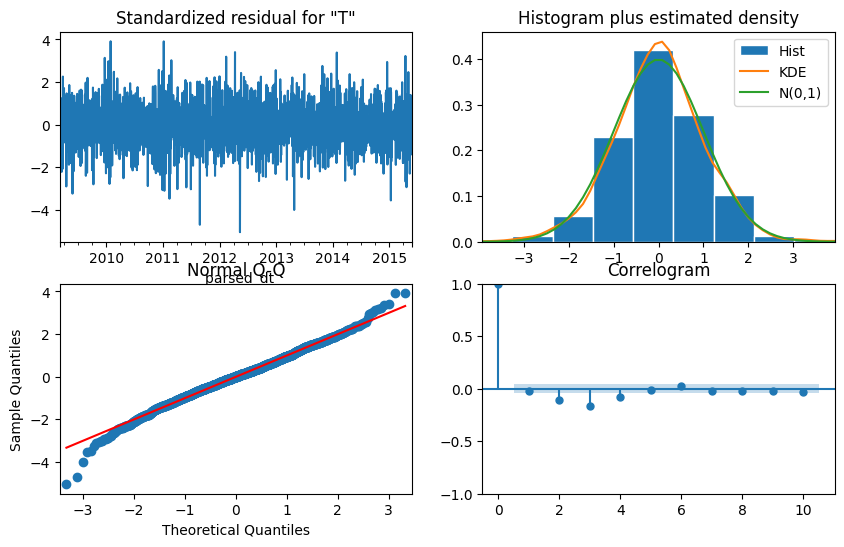

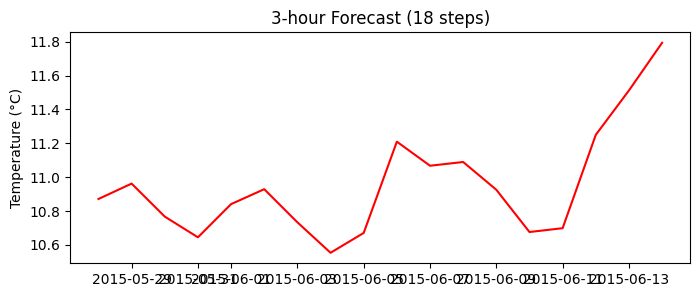

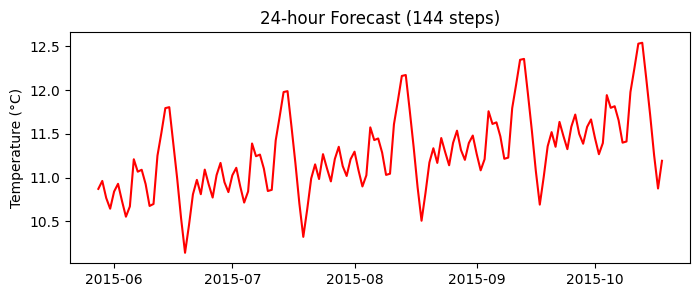

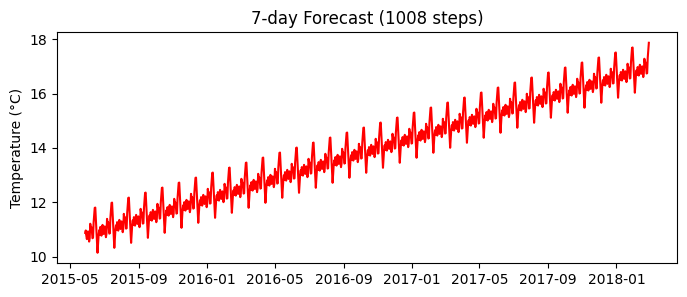

In [13]:
# === Optimized SARIMA Model (Auto seasonal speed mode) ===
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --------------------------------------------------------------------
# 1️⃣ Prepare daily temperature data
y_day = df['T (degC)'].resample('1D').mean().dropna()
train_size = int(len(y_day) * 0.8)
y_train, y_test = y_day.iloc[:train_size], y_day.iloc[train_size:]

print(f"Train range: {y_train.index.min()} → {y_train.index.max()}")
print(f"Test  range: {y_test.index.min()} → {y_test.index.max()}")
print(f"Training samples: {len(y_train)}, Testing samples: {len(y_test)}")

# --------------------------------------------------------------------
# 2️⃣ Choose mode: FAST or FULL
FAST_MODE = True   # 🔁 change to False for final report run (365-day seasonality)

if FAST_MODE:
    seasonal_period = 30    # ~monthly pattern → faster
    print("⚡ Fast Mode ON — using monthly seasonality (m=30)")
else:
    seasonal_period = 365   # yearly pattern → slower but more accurate
    print("🕐 Full Mode ON — using yearly seasonality (m=365)")

# --------------------------------------------------------------------
# 3️⃣ Fit SARIMA with timer
start_time = time.time()
sarima = sm.tsa.statespace.SARIMAX(
    y_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,seasonal_period),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(maxiter=100, disp=False)
end_time = time.time()
print(f"✅ Model trained in {end_time - start_time:.2f} seconds")

# --------------------------------------------------------------------
# 4️⃣ Forecast & Evaluate
forecast = sarima.forecast(len(y_test))
forecast = pd.Series(forecast, index=y_test.index)

mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))
print(f"\n📈 SARIMA(1,1,1)(1,1,1,{seasonal_period}) — MAE: {mae:.3f} °C | RMSE: {rmse:.3f} °C")

# --------------------------------------------------------------------
# 5️⃣ Plot: Actual vs Forecast (last year)
plt.figure(figsize=(12,5))
plt.plot(y_test[-365:], label="True", color="black")
plt.plot(forecast[-365:], label="SARIMA Forecast", color="red", linestyle="--")
plt.title(f"SARIMA(1,1,1)(1,1,1,{seasonal_period}) — Forecast vs True (Last Year)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# --------------------------------------------------------------------
# 6️⃣ Residual diagnostics
sarima.plot_diagnostics(figsize=(10,6))
plt.show()

# --------------------------------------------------------------------
# 7️⃣ Multi-horizon forecasts
for steps, label in zip([18, 144, 1008], ["3-hour", "24-hour", "7-day"]):
    future_forecast = sarima.forecast(steps=steps)
    plt.figure(figsize=(8,3))
    plt.plot(future_forecast, color="red")
    plt.title(f"{label.capitalize()} Forecast ({steps} steps)")
    plt.ylabel("Temperature (°C)")
    plt.show()


In [47]:
from statsmodels.tsa.arima.model import ARIMA

model_arma = ARIMA(y_train, order=(2,2,0))
fitted_arma = model_arma.fit()


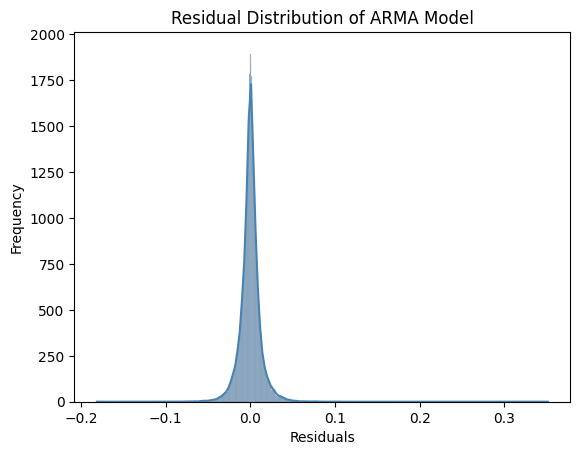

In [48]:
sns.histplot(fitted_arma.resid, kde=True, color='steelblue')
plt.title("Residual Distribution of ARMA Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


Part E — Multivariate & Deep Learning Models

1. Build VAR/VARMA models using a subset of correlated features  
2. Build at least two deep learning models for sequence forecasting
(e.g., LSTM, GRU). Use appropriate input windowing (e.g., last
6–144 timesteps), normalization, and training/validation splits
3. Optionally, implement a Transformer-based time series model or
Temporal Convolutional Network (TCN) for extra credit.
4. Compare performance with previous classical models and include
computational cost (training time, inference time).

Step 1 — Prepare Data for Deep Learning

1) Feature selection (correlated subset)

/tmp/ipython-input-3491925868.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_feat = df[features_all].resample('1H').mean().dropna()   # hourly


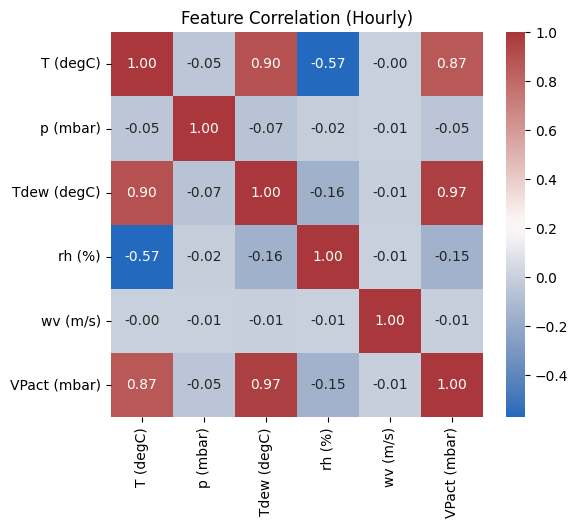

Correlation with target:
 T (degC)        1.000000
Tdew (degC)     0.896856
VPact (mbar)    0.869021
rh (%)          0.572049
p (mbar)        0.045223
wv (m/s)        0.004966
Name: T (degC), dtype: float64
Selected features: ['T (degC)', 'Tdew (degC)', 'VPact (mbar)', 'rh (%)', 'p (mbar)']


In [24]:
# choose a subset of correlated features automatically (you can override)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

features_all = ['T (degC)', 'p (mbar)', 'Tdew (degC)', 'rh (%)', 'wv (m/s)', 'VPact (mbar)']
df_feat = df[features_all].resample('1H').mean().dropna()   # hourly

# correlation matrix
corr = df_feat.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag')
plt.title('Feature Correlation (Hourly)')
plt.show()

# pick top correlated with target
target = 'T (degC)'
corr_with_target = corr[target].abs().sort_values(ascending=False)
print("Correlation with target:\n", corr_with_target)

# select top K (including target)
K = 5
selected = list(corr_with_target.index[:K])
print("Selected features:", selected)

df_sel = df_feat[selected].copy()


2) VAR (Vector Autoregression)

In [26]:
# VAR modeling (statsmodels)
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

# Use daily or hourly series depending on experiment; here hourly resampled above.
series = df_sel  # multivariate dataframe

# split
train_frac = 0.8
n = len(series)
train_end = int(n * train_frac)
train_series = series.iloc[:train_end]
test_series  = series.iloc[train_end:]

# find optimal lag with AIC/BIC
model = VAR(train_series)
lag_results = model.select_order(24)   # check lags up to 24
print(lag_results.summary())
best_lag = lag_results.selected_orders['aic'] or lag_results.selected_orders['bic'] or 12
print("Selected lag:", best_lag)

# fit VAR
start = time.perf_counter()
var_res = model.fit(best_lag)
train_time = time.perf_counter() - start
print(f"VAR fitted in {train_time:.2f} s")

# forecast horizon = len(test)
h = len(test_series)
start = time.perf_counter()
var_forecast = var_res.forecast(y=train_series.values[-best_lag:], steps=h)
infer_time = time.perf_counter() - start
var_pred_df = pd.DataFrame(var_forecast, index=test_series.index, columns=train_series.columns)

# Evaluate only target column
y_true = test_series[target].values
y_pred_var = var_pred_df[target].values
mae_var = mean_absolute_error(y_true, y_pred_var)
rmse_var = mean_squared_error(y_true, y_pred_var) ** 0.5
print("VAR MAE, RMSE:", mae_var, rmse_var, "train_time(s):", train_time, "infer_time(s):", infer_time)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        12.91       12.91   4.043e+05       12.91
1       -7.109      -7.104   0.0008175      -7.108
2       -9.047      -9.038   0.0001177      -9.044
3       -9.109      -9.096   0.0001107      -9.105
4       -9.172      -9.155   0.0001039      -9.167
5       -9.187      -9.166   0.0001024      -9.181
6       -9.195      -9.170   0.0001015      -9.187
7       -9.203      -9.174   0.0001008      -9.194
8       -9.210      -9.177   0.0001001      -9.199
9       -9.218      -9.181   9.927e-05      -9.206
10      -9.233      -9.193   9.774e-05      -9.221
11      -9.253      -9.208   9.581e-05      -9.239
12      -9.273      -9.224   9.397e-05      -9.257
13      -9.292      -9.239   9.219e-05      -9.275
14      -9.307      -9.251   9.076e-05      -9.290
15      -9.323      -9.263   8.932e-05      -9.304
16      -9.343      -9.279   8.

3) Sequence data creation (for LSTM/GRU/Transformer)

In [27]:
# sliding windows generator (multivariate)
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model

WINDOW = 72  # lookback (change to 6,24,72,144 as experiments)
HORIZON = 1  # one-step ahead forecasting; for multi-step set >1

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_sel)   # scale all features together
dates = df_sel.index

# create X,y where y is target at t+HORIZON
def create_sequences_multivariate(X, window=72, horizon=1, target_col=0):
    Xs, ys = [], []
    for i in range(window, len(X)-horizon+1):
        Xs.append(X[i-window:i])
        ys.append(X[i+ horizon -1, target_col])  # predict target at step i+horizon-1
    return np.array(Xs), np.array(ys)

target_col_index = list(df_sel.columns).index(target)
X_all, y_all = create_sequences_multivariate(data_scaled, WINDOW, HORIZON, target_col_index)
print("X_all shape:", X_all.shape, "y_all shape:", y_all.shape)

# train/test split
split = int(0.8 * len(X_all))
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

# inverse transform helper (target only)
def inv_transform_target(scaled_values):
    # scaled_values shape (n,1), create dummy features to inverse transform then take target col
    dummy = np.zeros((len(scaled_values), data_scaled.shape[1]))
    dummy[:, target_col_index:target_col_index+1] = scaled_values.reshape(-1,1)
    inv = scaler.inverse_transform(dummy)[:, target_col_index]
    return inv


X_all shape: (69969, 72, 5) y_all shape: (69969,)


4) LSTM & GRU models (with timing)

In [31]:
# ===============================
# 🧠 BLOCK 1 — MODEL TRAINING
# ===============================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time
import numpy as np

In [32]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Parameters
BATCH = 64
EPOCHS = 20
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [33]:
# --- 1️⃣ LSTM Model ---
model_lstm = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

start = time.perf_counter()
hist_lstm = model_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[es],
    verbose=1
)
train_time_lstm = time.perf_counter() - start

Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 74s 89ms/step - loss: 0.0042 - val_loss: 3.2273e-04
Epoch 2/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - loss: 2.7805e-04 - val_loss: 1.8949e-04
Epoch 3/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - loss: 1.9375e-04 - val_loss: 1.5347e-04
Epoch 4/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - loss: 1.6018e-04 - val_loss: 1.5663e-04
Epoch 5/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - loss: 1.4246e-04 - val_loss: 1.4275e-04
Epoch 6/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 1.3053e-04 - val_loss: 1.2616e-04
Epoch 7/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - loss: 1.2300e-04 - val_loss: 1.1043e-04
Epoch 8/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 1.1818e-04 - val_loss: 9.7140e-05
Epoch 9/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - loss: 1.1451e-04 - val_loss: 9.0474e-05
Epoch 10/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - loss: 1.1161e-04 - val_loss: 8.8206e-05
Epoch 11/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 36

In [34]:
# --- 2️⃣ GRU Model ---
model_gru = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(64),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')

start = time.perf_counter()
hist_gru = model_gru.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[es],
    verbose=1
)
train_time_gru = time.perf_counter() - start

Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 0.0054 - val_loss: 2.1459e-04
Epoch 2/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - loss: 1.8971e-04 - val_loss: 1.9016e-04
Epoch 3/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - loss: 1.5838e-04 - val_loss: 1.3840e-04
Epoch 4/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 55s 69ms/step - loss: 1.4017e-04 - val_loss: 1.2466e-04
Epoch 5/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - loss: 1.3179e-04 - val_loss: 1.2282e-04
Epoch 6/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 83s 64ms/step - loss: 1.2737e-04 - val_loss: 1.1892e-04
Epoch 7/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - loss: 1.2426e-04 - val_loss: 1.1608e-04
Epoch 8/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - loss: 1.2203e-04 - val_loss: 1.1592e-04
Epoch 9/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - loss: 1.2071e-04 - val_loss: 1.2377e-04
Epoch 10/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - loss: 1.2077e-04 - val_loss: 1.4354e-04
Epoch 11/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 50

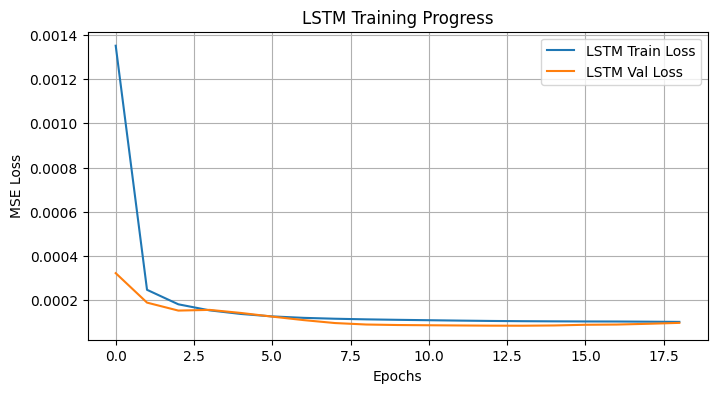

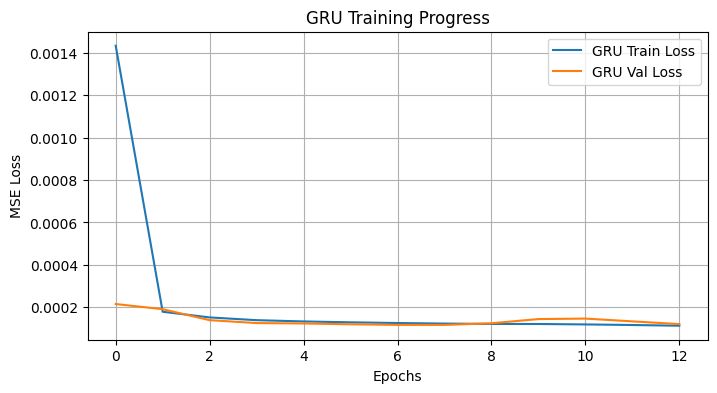

In [35]:
# --- 📈 Plot training progress ---
plt.figure(figsize=(8,4))
plt.plot(hist_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(hist_lstm.history['val_loss'], label='LSTM Val Loss')
plt.title('LSTM Training Progress')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist_gru.history['loss'], label='GRU Train Loss')
plt.plot(hist_gru.history['val_loss'], label='GRU Val Loss')
plt.title('GRU Training Progress')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

BLOCK 2 — Evaluation (with MAE & RMSE)

In [36]:
# ===============================
# 📊 BLOCK 2 — MODEL EVALUATION
# ===============================

from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

# --- Predict on Test Data ---
start = time.perf_counter()
pred_lstm_scaled = model_lstm.predict(X_test, batch_size=BATCH)
infer_time_lstm = time.perf_counter() - start

start = time.perf_counter()
pred_gru_scaled = model_gru.predict(X_test, batch_size=BATCH)
infer_time_gru = time.perf_counter() - start

# --- Inverse Transform ---
pred_lstm = inv_transform_target(pred_lstm_scaled)
pred_gru = inv_transform_target(pred_gru_scaled)
y_test_inv = inv_transform_target(y_test)

# --- Compute Metrics ---
mae_lstm = mean_absolute_error(y_test_inv, pred_lstm)
rmse_lstm = mean_squared_error(y_test_inv, pred_lstm) ** 0.5

mae_gru = mean_absolute_error(y_test_inv, pred_gru)
rmse_gru = mean_squared_error(y_test_inv, pred_gru) ** 0.5

# --- Print Summary ---
print("📊 FINAL MODEL PERFORMANCE (°C):")
print("--------------------------------")
print(f"LSTM → MAE: {mae_lstm:.3f}, RMSE: {rmse_lstm:.3f}, Train(s): {train_time_lstm:.2f}, Infer(s): {infer_time_lstm:.2f}")
print(f"GRU  → MAE: {mae_gru:.3f}, RMSE: {rmse_gru:.3f}, Train(s): {train_time_gru:.2f}, Infer(s): {infer_time_gru:.2f}")


219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
📊 FINAL MODEL PERFORMANCE (°C):
--------------------------------
LSTM → MAE: 0.407, RMSE: 0.585, Train(s): 827.92, Infer(s): 10.53
GRU  → MAE: 0.503, RMSE: 0.692, Train(s): 722.48, Infer(s): 5.19


Simple Transformer encoder for time-series

In [38]:
# ================================================================
# 🔹 Transformer Model for Time Series Forecasting
# ================================================================
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Input
from tensorflow.keras import Model
import time

def build_transformer(seq_len, n_features, d_model=64, num_heads=4, ff_dim=128, dropout=0.1):
    inp = Input(shape=(seq_len, n_features))
    x = Dense(d_model)(inp)

    # --- Multi-head Self Attention ---
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
    x = LayerNormalization()(x + attn_out)

    # --- Feed-Forward Layer ---
    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(d_model)(ff)
    x = LayerNormalization()(x + ff)

    # --- Global Pooling & Output ---
    x = GlobalAveragePooling1D()(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse')
    return model

# ---------------------------------------------------------------
# ⚙️ Build model
# ---------------------------------------------------------------
model_trans = build_transformer(X_train.shape[1], X_train.shape[2], d_model=64, num_heads=4)
model_trans.summary()

# ---------------------------------------------------------------
# 🚀 Train Transformer model
# ---------------------------------------------------------------
start = time.perf_counter()
history_trans = model_trans.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[es],
    verbose=1
)
train_time_trans = time.perf_counter() - start
print(f"✅ Training complete in {train_time_trans:.2f} seconds")


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 72, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 72, 64)    │        384 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 72, 64)    │     16,640 │ dense_9[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 72, 64)    │          0 │ dense_9[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 72, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 72, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 72, 64)    │      8,256 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 72, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 72, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         65 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,921 (132.50 KB)

 Trainable params: 33,921 (132.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 99s 103ms/step - loss: 0.2366 - val_loss: 0.0038
Epoch 2/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 3/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 4/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 5/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 81s 94ms/step - loss: 0.0048 - val_loss: 0.0065
Epoch 6/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 72s 91ms/step - loss: 0.0048 - val_loss: 0.0052
✅ Training complete in 476.10 seconds


219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step
✅ TRANSFORMER MAE: 3.112 °C | RMSE: 3.921 °C
⏱️ Train time: 476.10s | Inference time: 10.41s


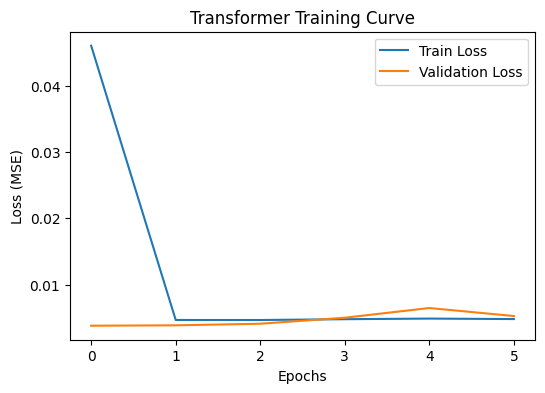

In [39]:
# ================================================================
# 🔹 Evaluate Transformer Model Performance
# ================================================================
start = time.perf_counter()
pred_trans_scaled = model_trans.predict(X_test, batch_size=BATCH)
infer_time_trans = time.perf_counter() - start

# --- Inverse scaling ---
pred_trans = inv_transform_target(pred_trans_scaled)

# --- Metrics ---
mae_trans = mean_absolute_error(y_test_inv, pred_trans)
rmse_trans = mean_squared_error(y_test_inv, pred_trans) ** 0.5

print(f"✅ TRANSFORMER MAE: {mae_trans:.3f} °C | RMSE: {rmse_trans:.3f} °C")
print(f"⏱️ Train time: {train_time_trans:.2f}s | Inference time: {infer_time_trans:.2f}s")

# Optional: Plot training vs validation loss
plt.figure(figsize=(6,4))
plt.plot(history_trans.history['loss'], label='Train Loss')
plt.plot(history_trans.history['val_loss'], label='Validation Loss')
plt.title("Transformer Training Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


Performance table and bar chart

   Model       MAE      RMSE     Train_s    Infer_s
0    VAR  6.717142  8.281705    2.183310   1.238184
1   LSTM  0.406825  0.584760  827.923734  10.525412
2    GRU  0.503075  0.692122  722.484251   5.189028
3  TRANS  3.112109  3.920725  476.102640  10.405875


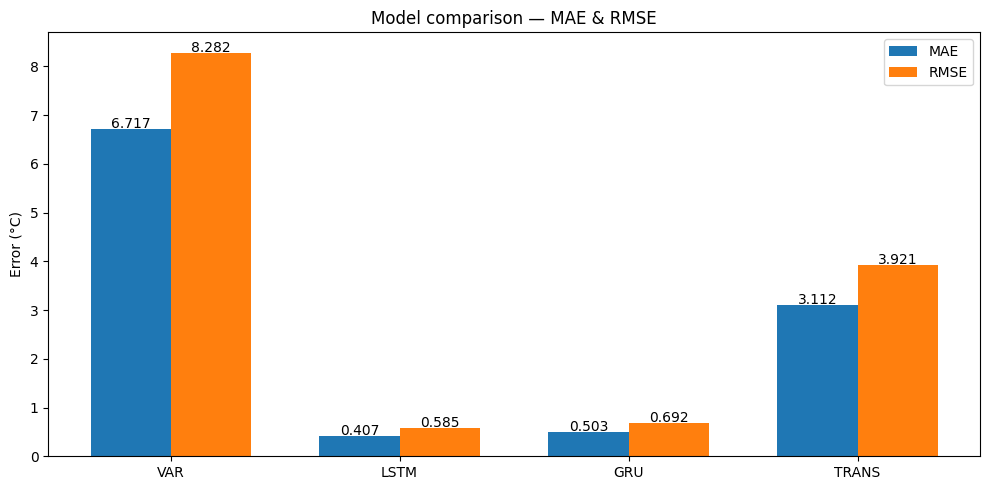

   Model     Train_s    Infer_s
0    VAR    2.183310   1.238184
1   LSTM  827.923734  10.525412
2    GRU  722.484251   5.189028
3  TRANS  476.102640  10.405875


In [40]:
# collect results
results = {
    'VAR': (mae_var, rmse_var, train_time, infer_time),
    'LSTM': (mae_lstm, rmse_lstm, train_time_lstm, infer_time_lstm),
    'GRU': (mae_gru, rmse_gru, train_time_gru, infer_time_gru),
}
# optional transformer
try:
    results['TRANS'] = (mae_trans, rmse_trans, train_time_trans, infer_time_trans)
except NameError:
    pass

import pandas as pd
res_df = pd.DataFrame.from_dict(results, orient='index', columns=['MAE','RMSE','Train_s','Infer_s']).reset_index().rename(columns={'index':'Model'})
print(res_df)

# bar chart MAE & RMSE side-by-side
import matplotlib.pyplot as plt, numpy as np
models = res_df['Model'].tolist()
mae_vals = res_df['MAE'].values
rmse_vals = res_df['RMSE'].values
x = np.arange(len(models)); w=0.35

plt.figure(figsize=(10,5))
plt.bar(x - w/2, mae_vals, w, label='MAE')
plt.bar(x + w/2, rmse_vals, w, label='RMSE')
plt.xticks(x, models)
plt.ylabel('Error (°C)')
plt.title('Model comparison — MAE & RMSE')
for i,v in enumerate(mae_vals): plt.text(i - w/2, v+0.02, f"{v:.3f}", ha='center')
for i,v in enumerate(rmse_vals): plt.text(i + w/2, v+0.02, f"{v:.3f}", ha='center')
plt.legend(); plt.tight_layout(); plt.show()

# table of compute times
print(res_df[['Model','Train_s','Infer_s']])
